In [122]:
%matplotlib inline
import re
from tensorflow.keras.callbacks import EarlyStopping
import warnings
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.activations import relu,sigmoid
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
import os
for dirname, _, filenames in os.walk('./'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./test.csv
./train.csv
./gender_submission.csv
./model_predict.ipynb


In [123]:
train_data = pd.read_csv('./train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [124]:
print(f"The dimensions of the training set are {train_data.shape}")

The dimensions of the training set are (891, 12)


In [125]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [126]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [127]:
train_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Features?
Age, Fare, Sex (hot-encoded value), Engineered Title (hot-encoded value), Pclass, Sibsp, Parch 

In [128]:
# import again to ensure stable testing
train_data = pd.read_csv('./train.csv')

# drop irrelevant columns and fill NaN age with average
def drop_irrev_col(df):
    # change index
    df.set_index('PassengerId',inplace=True)
    # drop some irrelevant features
    df.drop(['Ticket', 'Cabin','Embarked'], axis=1, inplace=True)
    # fill NaN age with average
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    return df

def feature_engineering(df):
    # RegEx to extract titles and print them
    #df['Title'] = df['Name'].str.extract(r'(\w+)(?=\.)')
    #if(df.Title.isnull().sum()!=0):
    #    warnings.warn("NaN values are found in Titles. Fix before moving on.")
    #print(f"Titles found are {df.Title.unique()}")
    df.drop('Name', axis=1, inplace=True)
    # one-hot encode sex and titles
    #df_new = pd.get_dummies(df, columns=['Sex','Title'],dtype=int)
    df_new = pd.get_dummies(df, columns=['Sex'],dtype=int)
    return df_new

# separate the training set into features dataframe and target data series
def features_and_target(df):
    # everything but survived is a feature
    features = [i for i in df.columns.tolist() if i!= 'Survived']
    X = df [features]
    # binary target
    Y = df['Survived']
    return X, Y

# clean the data
clean_train_data = drop_irrev_col(train_data)
clean_train_data = feature_engineering(clean_train_data)
# separate features and targets
X_train, y_train = features_and_target(clean_train_data)

X_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male
PassengerId,,,,,,,
1,3,22.0,1,0,7.2500,0,1
2,1,38.0,1,0,71.2833,1,0
3,3,26.0,0,0,7.9250,1,0
4,1,35.0,1,0,53.1000,1,0
5,3,35.0,0,0,8.0500,0,1


In [129]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Age         891 non-null    float64
 2   SibSp       891 non-null    int64  
 3   Parch       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   Sex_female  891 non-null    int64  
 6   Sex_male    891 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 55.7 KB


In [130]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 891 entries, 1 to 891
Series name: Survived
Non-Null Count  Dtype
--------------  -----
891 non-null    int64
dtypes: int64(1)
memory usage: 13.9 KB


# Scaling Age?
Let's try without first and see diagnostics

# Build the model

In [131]:
model = Sequential(
    [
        Dense(16, activation='relu', name="L_i"),
        Dense(10, activation='relu',kernel_regularizer=l2(0.05), name= "L_ii"),
        Dense(8, activation='relu',name= "L_iii"),
        Dense(3, activation='relu', kernel_regularizer=l2(0.05),name= "L_iv"),
        Dense(1, activation='linear', name="Output")

    ]
)
model.compile(
    loss=BinaryCrossentropy(from_logits=True),
    optimizer=Adam(0.0001),
    metrics=['accuracy']
)

# build the model and specify input dimensions
model.build(input_shape=(None, X_train.shape[1]))
# Store the initial weights
initial_weights = model.get_weights()

# Function to reset to initial weights
def reset_to_initial_weights(model, initial_weights):
    model.set_weights(initial_weights)

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L_i (Dense)                 (None, 16)                128       
                                                                 
 L_ii (Dense)                (None, 10)                170       
                                                                 
 L_iii (Dense)               (None, 8)                 88        
                                                                 
 L_iv (Dense)                (None, 3)                 27        
                                                                 
 Output (Dense)              (None, 1)                 4         
                                                                 
Total params: 417 (1.63 KB)
Trainable params: 417 (1.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [132]:
# Example usage:
reset_to_initial_weights(model, initial_weights)

# if loss is not improving within 10 epochs, stop and get the best one
early_stop = EarlyStopping(monitor='val_loss', patience=150, restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=1000, batch_size=4 ,validation_split = 0.2, callbacks=[early_stop])


Epoch 1/10000
178/178 [==============================] - 1s 2ms/step - loss: 1.8450 - accuracy: 0.6419 - val_loss: 1.5299 - val_accuracy: 0.6927
Epoch 2/10000
178/178 [==============================] - 0s 2ms/step - loss: 1.5413 - accuracy: 0.6601 - val_loss: 1.4136 - val_accuracy: 0.7039
Epoch 3/10000
178/178 [==============================] - 0s 2ms/step - loss: 1.4181 - accuracy: 0.6545 - val_loss: 1.3888 - val_accuracy: 0.6592
Epoch 4/10000
178/178 [==============================] - 0s 2ms/step - loss: 1.3733 - accuracy: 0.6180 - val_loss: 1.3431 - val_accuracy: 0.6704
Epoch 5/10000
178/178 [==============================] - 0s 2ms/step - loss: 1.3297 - accuracy: 0.6208 - val_loss: 1.3054 - val_accuracy: 0.6536
Epoch 6/10000
178/178 [==============================] - 0s 2ms/step - loss: 1.2885 - accuracy: 0.6208 - val_loss: 1.2649 - val_accuracy: 0.6592
Epoch 7/10000
178/178 [==============================] - 0s 1ms/step - loss: 1.2493 - accuracy: 0.6292 - val_loss: 1.2253 - val_ac

KeyboardInterrupt: 

In [40]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


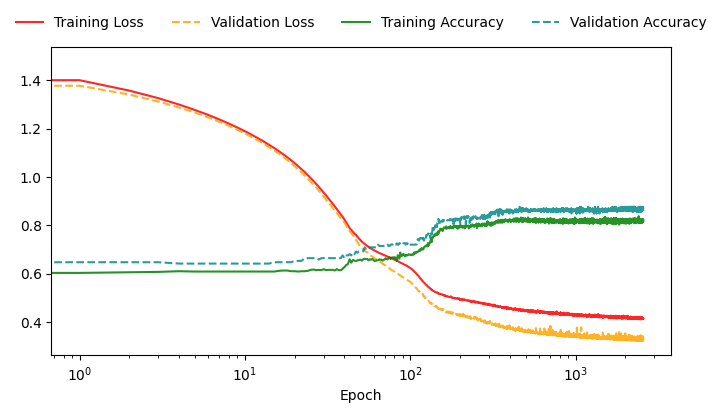

In [104]:
loss = history.history['loss']
accuracy = history.history['accuracy']
plt.figure(figsize=(8, 4));
to_plot = [history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']]
label = ['Training Loss','Validation Loss','Training Accuracy','Validation Accuracy']
colors = ['red','orange','green', 'darkcyan']
style = ['-','--','-','--']


for i,j,k,l in zip(to_plot, colors, label, style):
    plt.plot(i, label=k, color=j, linestyle=l, alpha=0.85)
plt.legend(bbox_to_anchor=(0.5,1.08), loc='center', frameon=False, ncol=4, prop={'size': 10})
plt.xscale('log')
plt.xlabel('Epoch');

In [106]:

threshold = np.linspace(0.5,0.75,20)
yhat = model.predict(X_train)
yhat = tf.math.sigmoid(yhat)
thresh_list = []
accuracy_list = []
for i in threshold:
    yhat = np.where(yhat>=i, 1, 0)
    yhat_series = pd.Series(yhat.ravel())
    yhat_series.index = y_train.index
    yhat_series.name = y_train.name
    accuracy = (y_train == yhat_series).mean()
    thresh_list.append(i)
    accuracy_list.append(accuracy)
best_threshold = thresh_list[np.argmax(accuracy_list)]


28/28 [==============================] - 0s 1ms/step


0.5

In [117]:
test_data = pd.read_csv('./test.csv')


In [109]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [118]:
clean_test_data['Survived']=0
clean_test_data = drop_irrev_col(test_data)
clean_test_data = feature_engineering(clean_test_data)
X_test,_ = features_and_target(clean_test_data)

Titles found are ['Mr' 'Mrs' 'Miss' 'Master' 'Ms' 'Col' 'Rev' 'Dr' 'Dona']


KeyError: 'Survived'

In [119]:
predictions = model.predict(X_test)

InvalidArgumentError: Graph execution error:

Detected at node 'sequential_9/L_i/Relu' defined at (most recent call last):
    File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/omar/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/omar/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
      handle._run()
    File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/omar/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell
      result = self._run_cell(
    File "/home/omar/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell
      result = runner(coro)
    File "/home/omar/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/omar/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/omar/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/omar/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_29496/4109673188.py", line 1, in <module>
      predictions = model.predict(X_test)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 2283, in predict_step
      return self(x, training=False)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py", line 255, in call
      outputs = self.activation(outputs)
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/home/omar/.local/lib/python3.10/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential_9/L_i/Relu'
Matrix size-incompatible: In[0]: [32,16], In[1]: [24,16]
	 [[{{node sequential_9/L_i/Relu}}]] [Op:__inference_predict_function_5967410]

In [116]:
print(X_train.shape)
print(X_test.shape)

(891, 24)
(418, 16)
